<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/Policy_Iteration_Script_exp7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Policy Iteration...
Iteration 1: Evaluating Policy...
Iteration 1: Improving Policy...
Iteration 2: Evaluating Policy...
Iteration 2: Improving Policy...
Iteration 3: Evaluating Policy...
Iteration 3: Improving Policy...
Optimal Policy found after 3 iterations!


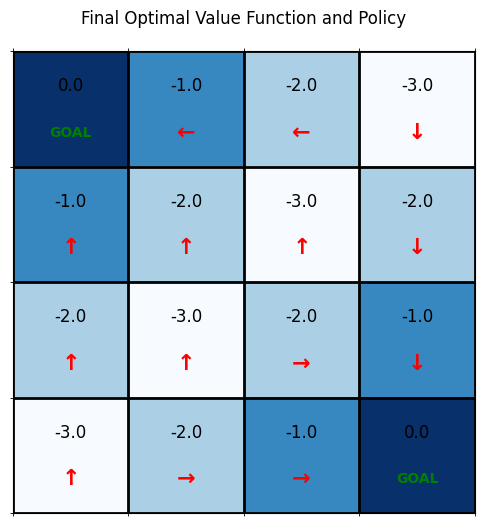

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the Environment (Markov Decision Process)
class GridworldEnv:
    """
    A 4x4 Gridworld where the goal is to reach the terminal states (0 or 15).
    Actions: 0: UP, 1: RIGHT, 2: DOWN, 3: LEFT
    Reward: -1 for every step until a terminal state is reached.
    """
    def __init__(self, shape=[4, 4]):
        self.shape = shape
        self.nS = np.prod(shape) # 16 states
        self.nA = 4              # 4 actions
        self.P = {}              # Transition dynamics P[s][a] = [(prob, next_state, reward, is_done)]

        # Build the transition dynamics
        for s in range(self.nS):
            self.P[s] = {a: [] for a in range(self.nA)}
            is_terminal = (s == 0 or s == self.nS - 1)

            if is_terminal:
                for a in range(self.nA):
                    self.P[s][a] = [(1.0, s, 0, True)]
            else:
                row, col = np.unravel_index(s, self.shape)
                for a in range(self.nA):
                    next_row, next_col = row, col
                    if a == 0: next_row = max(row - 1, 0)                  # UP
                    elif a == 1: next_col = min(col + 1, self.shape[1] - 1) # RIGHT
                    elif a == 2: next_row = min(row + 1, self.shape[0] - 1) # DOWN
                    elif a == 3: next_col = max(col - 1, 0)                  # LEFT

                    next_state = np.ravel_multi_index((next_row, next_col), self.shape)
                    self.P[s][a] = [(1.0, next_state, -1, False)]

# 2. Policy Evaluation
def policy_evaluation(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    Calculates the State-Value function V(s).
    """
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # Iterate over all states
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # Look at the possible next states...
                for prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value (Bellman Equation for V)
                    v += action_prob * prob * (reward + discount_factor * V[next_state])

            # Calculate absolute change for convergence check
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return V

# 3. Policy Improvement
def policy_improvement(env, policy, V, discount_factor=1.0):
    """
    Given a Value function, greedily update the policy.
    """
    policy_stable = True

    for s in range(env.nS):
        # The best action we would take under the current policy
        chosen_a = np.argmax(policy[s])

        # Find the best action by looking one step ahead
        action_values = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[s][a]:
                action_values[a] += prob * (reward + discount_factor * V[next_state])

        best_a = np.argmax(action_values)

        # Greedily update the policy
        if chosen_a != best_a:
            policy_stable = False

        policy[s] = np.eye(env.nA)[best_a] # Set probability of best action to 1, others to 0

    return policy, policy_stable

# 4. Visualization Helper
def plot_gridworld(V, policy, shape, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(V.reshape(shape), cmap='Blues')

    action_symbols = {0: '↑', 1: '→', 2: '↓', 3: '←'}

    for s in range(len(V)):
        row, col = np.unravel_index(s, shape)
        # Add Value text
        val_text = f"{V[s]:.1f}"
        ax.text(col, row - 0.2, val_text, va='center', ha='center', color='black', fontsize=12)

        # Add Policy Arrow
        if s != 0 and s != len(V) - 1: # Skip terminal states
            best_action = np.argmax(policy[s])
            ax.text(col, row + 0.2, action_symbols[best_action], va='center', ha='center', color='red', fontsize=16, weight='bold')
        else:
            ax.text(col, row + 0.2, "GOAL", va='center', ha='center', color='green', fontsize=10, weight='bold')

    ax.set_xticks(np.arange(-.5, shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.set_xticks([]); ax.set_yticks([])
    plt.title(title, pad=20)
    plt.show()

# 5. Execute Policy Iteration
if __name__ == "__main__":
    env = GridworldEnv()

    # Start with a random policy (25% chance for each action in every state)
    policy = np.ones([env.nS, env.nA]) / env.nA

    print("Starting Policy Iteration...")
    iteration = 1

    while True:
        print(f"Iteration {iteration}: Evaluating Policy...")
        # 1. Evaluate current policy
        V = policy_evaluation(policy, env)

        print(f"Iteration {iteration}: Improving Policy...")
        # 2. Improve current policy
        policy, policy_stable = policy_improvement(env, policy, V)

        if policy_stable:
            print(f"Optimal Policy found after {iteration} iterations!")
            break

        iteration += 1

    # Plot the final results
    plot_gridworld(V, policy, env.shape, "Final Optimal Value Function and Policy")